# **Práctica 1: Multiarmed bandits**

El objetivo de esta práctica es construir un sistema automático de aprendizaje por refuerzo para gestionar un sistema de concesión de créditos.
La idea es que cuando un cliente contacte con el banco para solicitar un crédito, el sistema se lo conceda (acción 1) o no (acción 0).
Por tanto el sistema de aprendizaje por refuerzo tiene **dos posibles acciones**.

Por otra parte, el reward obtenido es:

- 0 si el sistema decide no ofrecerle el crédito al cliente
- 1 si se le ofrece el crédito y **lo paga**
- -5 si se le ofrece crédito y **no lo paga**

Para construir el sistema disponemos del siguiente dataset: https://drive.google.com/file/d/1NNN5ZB68108zxiJWfZn6FjTrhnzKEQV3/view?usp=sharing


A continuación se descarga y muestra:

In [1]:
import pandas as pd
pd.options.display.max_colwidth = 200

# Descargamos dataset:
aux = "'https://docs.google.com/uc?export=download&id=1TdTDAjndt5sn_7HKwc1PifcaQTRNHzkR&confirm=t'"
!wget -q $aux -O ./cs.csv
aux = "'https://docs.google.com/uc?export=download&id=1fbACV5f_YTPFtetTqKgV3YEnkJ0xqoKJ&confirm=t'"
!wget -q $aux -O ./DataDictionary.csv

**Base de datos:**

In [2]:
df = pd.read_csv("./cs.csv")
df.head(3)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0


**Información sobre cada variable:**

In [3]:
info_variables = pd.read_csv("DataDictionary.csv", sep=";").set_index("Variable Name")
info_variables

,Unnamed: 0,Description,Type
Variable Name,,,
SeriousDlqin2yrs,0,Person experienced 90 days past due delinquency or worse,Y/N
RevolvingUtilizationOfUnsecuredLines,1,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
age,2,Age of borrower in years,integer
NumberOfTime30-59DaysPastDueNotWorse,3,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
DebtRatio,4,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
MonthlyIncome,5,Monthly income,real
NumberOfOpenCreditLinesAndLoans,6,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
NumberOfTimes90DaysLate,7,Number of times borrower has been 90 days or more past due.,integer
NumberRealEstateLoansOrLines,8,Number of mortgage and real estate loans including home equity lines of credit,integer


La columna **SeriousDlqin2yrs** es 0 si el cliente paga el crédito, y 1 si no lo paga.

Por otra parte reordenaremos aleatoriamente el dataset ya que simularemos que los clientes van contactando con nosotros sin ningún tipo de orden:

In [4]:
import numpy as np
df = df.iloc[np.random.permutation(len(df))]
df.head(3) # hago display de los 3 primeros clientes del dataset

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
34959,0,0.645418,32,0,0.149402,2422.0,3,0,0,0,1.0
134826,0,0.638815,71,0,2642.000000,NaN,9,0,1,0,0.0
58576,0,0.044932,41,0,1544.000000,NaN,3,0,1,0,0.0


# **Tareas a realizar**

1- Aborda el problema con un multiarmed bandit **no contextual** (un $\epsilon$-greedy). ¿Cuál es el reward promedio al que llega tu algoritmo? ¿cómo se compara respecto a un grupo de control donde la acción escogida es siempre aleatoria? Representa la evolución del reward total, regret total y reward promedio para $\epsilon=0.1$ y $\epsilon=0.01$

2- Aborda el problema con un multiarmed bandit **contextual**, donde las variables de contexto son todas las columnas del dataset menos **SeriousDlqin2yrs**. ¿Cuál es el reward promedio al que llega tu algoritmo? ¿cómo se compara respecto a un grupo de control donde la acción escogida es siempre aleatoria? Representa la evolución del reward total, regret total y reward promedio.


# **Entrega**

Se entregará un notebook con todo el código, gráficas y resultados comentados.

### TASK 1.

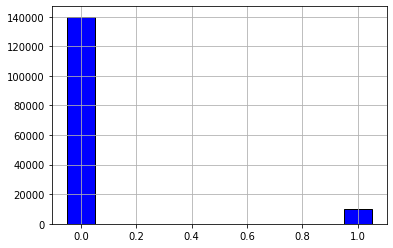

Clientes que pagan: 139974
Clientes que no pagan: 10026


In [5]:
import matplotlib.pyplot as plt
x, height = np.unique(df['SeriousDlqin2yrs'], return_counts=True)
plt.bar(x, height, width=0.1, color='blue', edgecolor='black')
plt.grid()
plt.show()

print(f'Clientes que pagan: {height[0]}\nClientes que no pagan: {height[1]}')

In [6]:
# Create a new column with rewards (1 if SeriousDlqin2yrs == 1 else -5).
df['Rewards'] = df['SeriousDlqin2yrs'].replace({0: +1, 1: -5})
df[['SeriousDlqin2yrs', 'Rewards']].head()

,SeriousDlqin2yrs,Rewards
34959,0,1
134826,0,1
58576,0,1
53314,0,1
19729,0,1


In [7]:
class Bandit():
  def __init__(self, rewards=None):
    self.maxpulls = len(df) # Number of clients.
    if rewards is not None: self.futurepulls = rewards.values
    else: self.futurepulls = np.zeros(self.maxpulls, dtype=int) # Vector de ceros para el bandit de no conceder.

    self.mean = np.mean(self.futurepulls)
  
  def pull(self, idx):
    aux = self.futurepulls[idx] # Get reward of client with index = idx.
    
    return aux

In [8]:
class Bandit_Estimation():
  def __init__(self):
    self.sum_rewards = 0
    self.N = 0
    self.mean = 0
  
  def update(self, reward):
    self.sum_rewards += reward
    self.N += 1
    self.mean = self.sum_rewards / self.N # Update Q(a) Estimation.

Se ha implementado el algoritmo $\epsilon$-greedy. Con probabilidad $\epsilon$ se escoge un acción aleatoria (entre conceder y no conceder) y con probabilidad $1 - \epsilon$ se escoge la acción con mayor valor estimado $\hat{Q}(a)$. Donde:

> * $\hat{Q}(a) = \frac{suma\ de\ refuerzos\ obtenidos\ con\ la\ acción\ a}{número\ de\ veces\ que\ se\ elige\ la\ acción\ a}$

A continuación, se muestran los resultados de Reward Total, Regret Total y Reward Promedio para distintos valores de $\epsilon$ [1 (completamente aleatorio), 0.1 y 0.01]. Adicionalmente, se ha implementado una estrategia de $\epsilon$-Decay en la que se inicializa $\epsilon = 1$ para permitir al modelo explorar al principio y gradualmente se decrementa su valor para permitir al modelo centrarse en la fase de explotación hasta un valor mínimo de $\epsilon=0.01$

In [9]:
from tqdm import tqdm

def run_experiment_egreedy(bandits, eps, eps_decay=1, vis=True):
  N_total = bandits[0].maxpulls # Number of clients.
  estimated_bandits = [Bandit_Estimation() for _ in bandits] 
  rewards = np.empty(N_total)

  for i in tqdm(range(N_total), desc='Clientes...'):
    prob = np.random.random()
    if prob < eps: 
      j = np.random.choice(len(bandits)) # Random action.
    else:
      j = np.argmax([b.mean for b in estimated_bandits]) # Select action with greater Q(a) estimation.

    reward = bandits[j].pull(i) # Get reward for client i.
    estimated_bandits[j].update(reward) # Update Q(a) estimation with new reward.

    rewards[i] = reward

    # Epsilon-Decay.
    eps = max(0.01, eps * eps_decay) # Set 0.01 as minimum epsilon.

  cumulative_reward  = np.cumsum(rewards)
  cumulative_average = cumulative_reward / (np.arange(N_total) + 1)  

  if vis:
    # plot moving average ctr
    plt.figure(figsize=(7,3))
    x = np.array(range(1, N_total+1))
    plt.plot(x, N_total*[bandits[0].mean], label='Bandit 0 Real Mean')
    plt.plot(x, N_total*[bandits[1].mean], label='Bandit 1 Real Mean')
    plt.plot(x, cumulative_average, label='Average Reward')
    plt.title('$\epsilon$-greedy, $\epsilon$={}'.format(eps), fontsize=16)
    plt.xscale('log')
    plt.legend(loc='best')
    plt.show()
    
    print(f'\nReward Promedio Alcanzado: {cumulative_average[-1]:.03f}')

    for i, b in enumerate(estimated_bandits):
        print('Bandit {} -> Seleccionado {} veces.'.format(i, b.N))
    
    
    
  return cumulative_reward, cumulative_average

Clientes...: 100%|██████████| 150000/150000 [00:06<00:00, 23512.53it/s]


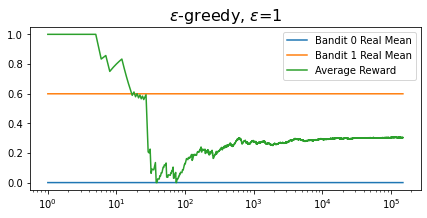


Reward Promedio Alcanzado: 0.304
Bandit 0 -> Seleccionado 74608 veces.
Bandit 1 -> Seleccionado 75392 veces.



Clientes...: 100%|██████████| 150000/150000 [00:06<00:00, 24597.58it/s]


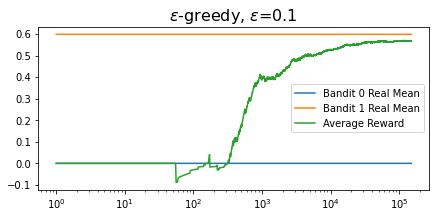


Reward Promedio Alcanzado: 0.567
Bandit 0 -> Seleccionado 7921 veces.
Bandit 1 -> Seleccionado 142079 veces.



Clientes...: 100%|██████████| 150000/150000 [00:03<00:00, 43833.28it/s]


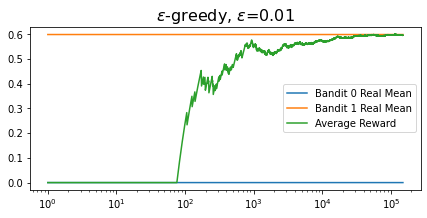


Reward Promedio Alcanzado: 0.596
Bandit 0 -> Seleccionado 847 veces.
Bandit 1 -> Seleccionado 149153 veces.



Clientes...: 100%|██████████| 150000/150000 [00:01<00:00, 75127.65it/s]


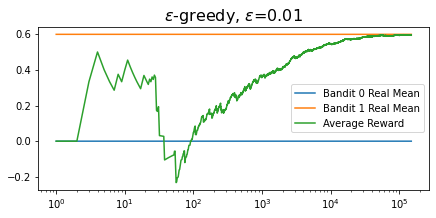


Reward Promedio Alcanzado: 0.594
Bandit 0 -> Seleccionado 1260 veces.
Bandit 1 -> Seleccionado 148740 veces.



In [10]:
epsilons = [1, 0.1, 0.01, 1] # (eps=1 para escoger siempre una acción aleatoria.)
total_rewards, average_rewards = [], []
for i, eps in enumerate(epsilons):
  bandit0 = Bandit() # No conceder (Reward siempre 0).
  bandit1 = Bandit(rewards=df['Rewards']) # Conceder.
  if i < 3: total_reward, average_reward = run_experiment_egreedy([bandit0, bandit1], eps)
  else: total_reward, average_reward = run_experiment_egreedy([bandit0, bandit1], eps, eps_decay=0.999) # Decaying egreedy.

  total_rewards.append(total_reward)
  average_rewards.append(average_reward)
  print()

In [11]:
def show_plots(total_rewards, average_rewards, optimal_gains, colors=['black', 'red', 'orange', 'blue']):
  print(f'Optimal Rewards: +{np.cumsum(optimal_gains)[-1]}')

  fig, axs = plt.subplots(1, 3, figsize=(25, 5))
  x = np.array(range(1, len(df)+1))
  labels = [f'$\epsilon$={eps}' for eps in [1, 0.1, 0.01]]
  labels.append('Decaying $\epsilon$-greedy')

  [axs[0].plot(x, total_reward, label=label, color=color, alpha=0.75) for total_reward, label, color in zip(total_rewards, labels, colors)]
  [axs[1].plot(x, np.cumsum(optimal_gains) - total_reward, label=label, color=color, alpha=0.75) for total_reward, label, color in zip(total_rewards, labels, colors)]
  [axs[2].plot(x, average_reward, label=label, color=color) for average_reward, label, color in zip(average_rewards, labels, colors)]

  [ax.set_xscale('log') for ax in axs.ravel()] # All plots in log scale.
  [ax.set_xlabel('log(Time Steps)') for ax in axs.ravel()]
  [ax.legend() for ax in axs.ravel()]
  [ax.set_title(title) for ax, title in zip(axs.ravel(), ['Reward Total', 'Regret Total', 'Reward Promedio'])]
  plt.show()

Optimal Rewards: +139974


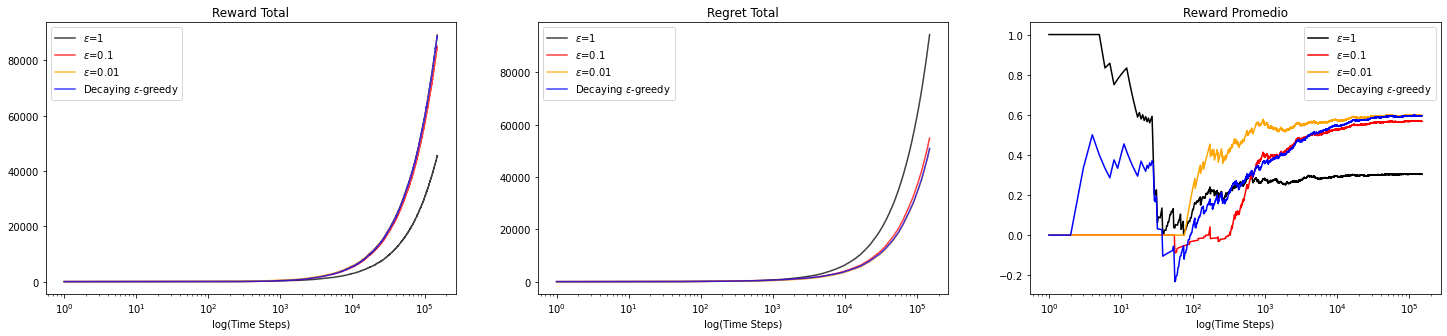

In [12]:
optimal_gains = [np.max([b.pull(i) for b in [bandit0, bandit1]]) for i in range(len(df))] # For each client select the action with the highest reward.

show_plots(total_rewards, average_rewards, optimal_gains)

Se observa que para $\epsilon = 1$ (completamente aleatorio) los resultados son significativamente peores para todas las métricas. Por otro lado, los mejores resultados se obtienen para $\epsilon = 0.01$ en el que se escoge la opción *greedy* en el 99.9% de las ocasiones y para la estrategia $\epsilon$-decay,  siendo el primero para la que mayor reward promedio se obtiene. En los gráficos de reward total y regret total apenas se aprecian diferencias entre el Multiarmed-Bandit con $\epsilon = 0.01$ y la estrategia $\epsilon$-decay, sin embargo, en el gráfico de reward promedio se aprecia que en esta última se ha explorado más al comienzo.

### TASK 2.

Para el Multiarmed-Bandit Contextual se ha modificado la forma en la que se escoge la opción *greedy* de la siguiente forma:

Para cada cliente se escoge la acción con mayor $Q_{\theta}(s, a) + k \sqrt{\sigma_{\theta}^2(s, a)}$. Donde:

> * $Q_{\theta}(s, a) = \phi(s, a)^T \theta$
> * $\sigma_{\theta}(s, a) = \phi(s, a)^T A^{-1} \phi(s, a)$
> * $\theta = A^{-1}b$
> * $A = \sum \phi(s, a) \phi(s, a)^T$
> * $b = \sum \phi(s, a) r$
> * $\phi(s, a)$ es el vector de contexto de cada usuario y $r$ la recompensa obtenida al ejecutar la acción.
> * $k$ es un hiperparámetro para controlar el intervalo de confianza de la estimación $Q_{\theta}(s, a)$. Cuanto mayor es $k$ el modelo realiza más exploración y menos explotación.

In [13]:
class Contextual_Bandit_Estimation():
  def __init__(self, N_vars):
    self.N = 0
    self.A = np.identity(N_vars)
    self.b = np.zeros(N_vars)

  def LinUCB(self, context, k):
    theta = np.linalg.inv(self.A) @ self.b # Compute weigth vector.
    Q = context @ theta # Compute Q estimation.
    var_Q = (context.reshape(1, -1) @ np.linalg.inv(self.A) @ context.reshape(-1, 1))[0, 0] # Compute variance of estimation.

    return Q + k * np.sqrt(var_Q)

  def update(self, context, reward):
    self.N += 1
    self.A += context.reshape(-1, 1) @ context.reshape(1, -1)
    self.b += context * reward

In [14]:
def run_contextual_egreedy(bandits, contexts, k, eps, eps_decay=1, vis=True):
  N_total = bandits[0].maxpulls  
  estimated_bandits = [Contextual_Bandit_Estimation(N_vars=contexts.shape[1]) for _ in bandits] 
  rewards = np.empty(N_total)

  for i in tqdm(range(N_total), desc='Clientes...'):
    context = contexts[i, :] # Get context vector of client.
    prob = np.random.random()
    if prob < eps: 
      j = np.random.choice(len(bandits)) 
    else:
      j = np.argmax([b.LinUCB(context, k) for b in estimated_bandits]) # Select greedy option.

    reward = bandits[j].pull(i) # Get reward.
    estimated_bandits[j].update(context, reward) # Update A and b with new context and reward.

    rewards[i] = reward

    # Epsilon-Decay.
    eps = max(0.01, eps * eps_decay) # Set 0.01 as minimum epsilon.

  cumulative_reward  = np.cumsum(rewards)
  cumulative_average = cumulative_reward / (np.arange(N_total) + 1)

  if vis:
    # plot moving average ctr
    plt.figure(figsize=(7,3))
    x = np.array(range(1, N_total+1))
    plt.plot(x, N_total*[bandits[0].mean], label='Bandit 0 Real Mean')
    plt.plot(x, N_total*[bandits[1].mean], label='Bandit 1 Real Mean')
    plt.plot(x, cumulative_average, label='Average Reward')
    plt.title('$\epsilon$-greedy, $\epsilon$={}'.format(eps), fontsize=16)
    plt.xscale('log')
    plt.legend(loc='best')
    plt.show()

    print(f'\nReward Promedio Alcanzado: {cumulative_average[-1]:.03f}')
    
    for i, b in enumerate(estimated_bandits):
        print('Bandit {} -> Seleccionado {} veces.'.format(i, b.N))
    
  return cumulative_reward, cumulative_average

Se ha comprobado que el valor de $k$ para el que se obtienen mejores resultados es para $k = 0$

Clientes...: 100%|██████████| 150000/150000 [00:09<00:00, 16290.42it/s]


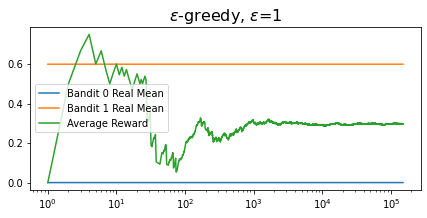


Reward Promedio Alcanzado: 0.298
Bandit 0 -> Seleccionado 75192 veces.
Bandit 1 -> Seleccionado 74808 veces.



Clientes...: 100%|██████████| 150000/150000 [00:24<00:00, 6070.60it/s]


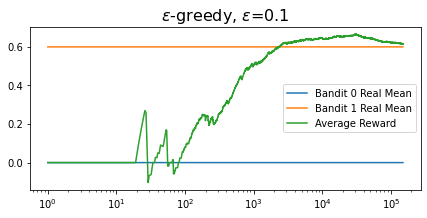


Reward Promedio Alcanzado: 0.614
Bandit 0 -> Seleccionado 12014 veces.
Bandit 1 -> Seleccionado 137986 veces.



Clientes...: 100%|██████████| 150000/150000 [00:25<00:00, 5885.80it/s]


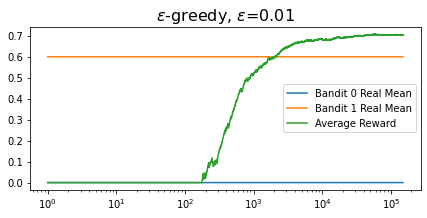


Reward Promedio Alcanzado: 0.702
Bandit 0 -> Seleccionado 14841 veces.
Bandit 1 -> Seleccionado 135159 veces.



Clientes...: 100%|██████████| 150000/150000 [00:25<00:00, 5844.26it/s]


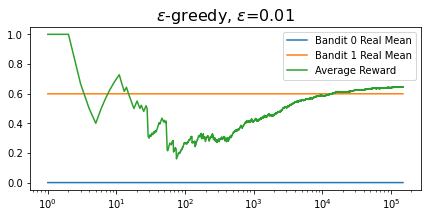


Reward Promedio Alcanzado: 0.644
Bandit 0 -> Seleccionado 5079 veces.
Bandit 1 -> Seleccionado 144921 veces.



In [17]:
context_columns = [column for column in df.columns if column not in ['SeriousDlqin2yrs', 'Rewards']]
contexts = df[context_columns].replace(np.nan, 0).values

epsilons = [1, 0.1, 0.01, 1] # eps=1 para escoger siempre una acción aleatoria.
total_rewards, average_rewards = [], []
for i, eps in enumerate(epsilons):
  bandit0 = Bandit() # No conceder (Reward siempre 0).
  bandit1 = Bandit(rewards=df['Rewards']) # Conceder.
  if i < 3: total_reward, average_reward = run_contextual_egreedy([bandit0, bandit1], contexts, k=0, eps=eps)
  else: total_reward, average_reward = run_contextual_egreedy([bandit0, bandit1], contexts, k=0, eps=eps, eps_decay=0.999) # Decaying egreedy.

  total_rewards.append(total_reward)
  average_rewards.append(average_reward)
  print()

Optimal Rewards: +139974


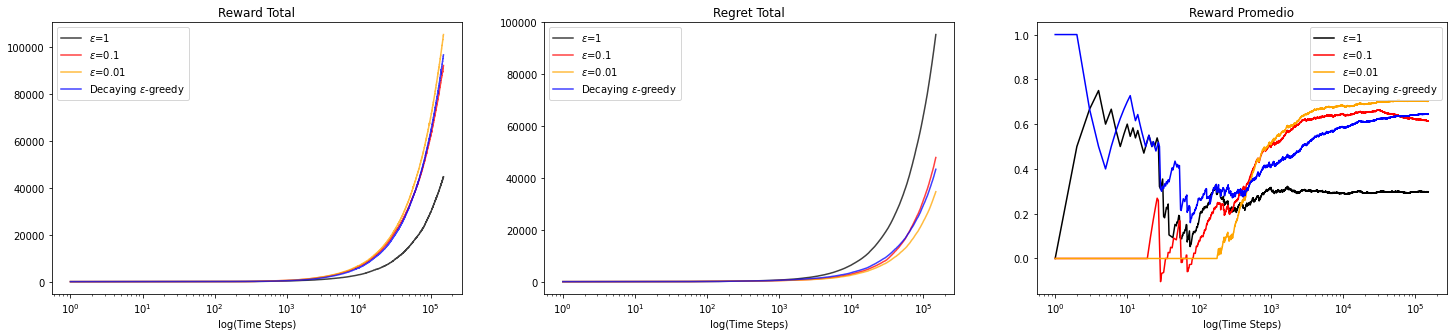

In [18]:
optimal_gains = [np.max([b.pull(i) for b in [bandit0, bandit1]]) for i in range(len(df))] # For each client select the action with the highest reward.

show_plots(total_rewards, average_rewards, optimal_gains)

Se observa que los resultados del Multiarmed-Bandit contextual son significativamente superiores a los del no contextual, esto posiblemente se debe a que en este caso se tiene en cuenta el contexto de cada cliente en la estimación del valor de las acciones.

De nuevo, el modelo alteatorio obtiene resultados significativamente peores que el resto de estrategias. En este caso, la estrategia que ofrece mejores resultados es fijar $\epsilon=0.01$ seguida de la estrategia de $\epsilon$-decay implementada alcanzando un reward promedio de 0.702